In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install monai==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.4 MB/s eta 0:00:00


In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel
from tqdm import tqdm
from monai import transforms
import gc

In [ ]:
root_dir = "/content/drive/MyDrive/BRATS_2021/BraTS2021/"
target_dir = "/content/drive/MyDrive/diff_repaint/data/"
dir_list = sorted(os.listdir(root_dir))
dir_list = dir_list[1:]

In [ ]:
print(len(dir_list))

1251


In [ ]:
print(dir_list)

['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_00008', 'BraTS2021_00009', 'BraTS2021_00011', 'BraTS2021_00012', 'BraTS2021_00014', 'BraTS2021_00016', 'BraTS2021_00017', 'BraTS2021_00018', 'BraTS2021_00019', 'BraTS2021_00020', 'BraTS2021_00021', 'BraTS2021_00022', 'BraTS2021_00024', 'BraTS2021_00025', 'BraTS2021_00026', 'BraTS2021_00028', 'BraTS2021_00030', 'BraTS2021_00031', 'BraTS2021_00032', 'BraTS2021_00033', 'BraTS2021_00035', 'BraTS2021_00036', 'BraTS2021_00043', 'BraTS2021_00044', 'BraTS2021_00045', 'BraTS2021_00046', 'BraTS2021_00048', 'BraTS2021_00049', 'BraTS2021_00051', 'BraTS2021_00052', 'BraTS2021_00053', 'BraTS2021_00054', 'BraTS2021_00056', 'BraTS2021_00058', 'BraTS2021_00059', 'BraTS2021_00060', 'BraTS2021_00061', 'BraTS2021_00062', 'BraTS2021_00063', 'BraTS2021_00064', 'BraTS2021_00066', 'BraTS2021_00068', 'BraTS2021_00070', 'BraTS2021_00071', 'BraTS2021_00072', 'BraTS2021_00074', 'BraTS2021_00077', 'BraTS2021_

In [ ]:
split_dict = {'train': 938, 'val': 62, 'test': 251}
import random
dir_train = sorted(random.sample(dir_list, split_dict['train']))
dir_val = sorted(random.sample([elem for elem in dir_list if elem not in dir_train], split_dict['val']))
dir_test = sorted([elem for elem in dir_list if (elem not in dir_train and elem not in dir_val)])

In [ ]:
print(len(dir_train))

938


In [ ]:
def normalize_image(image):

    temp_dict = {'image': image}

    transform = transforms.ScaleIntensityRangePercentilesd(
        keys="image",
        lower=0.0,
        upper=100.0,
        b_min=0.0,
        b_max=1.0
    )

    return transform(temp_dict)['image']

In [ ]:
def preprocess_batch(start, end, batch_idx, mode):

    data_dict = {
        "image": [],
        "label": [],
        "weak_label": [],
    }

    # count = 0

    patient_list = []

    if mode == 'train':
        patient_list = dir_train
    elif mode == 'val':
        patient_list = dir_val
    elif mode == 'test':
        patient_list = dir_test

    for dir in tqdm(patient_list[start:end]):
        # if count == 10:
        #     break
        t1_image_path = os.path.join(root_dir, dir, dir + '_t1.nii.gz')
        t1ce_image_path = os.path.join(root_dir, dir, dir + '_t1ce.nii.gz')
        t2_image_path = os.path.join(root_dir, dir, dir + '_t2.nii.gz')
        flair_image_path = os.path.join(root_dir, dir, dir + '_flair.nii.gz')
        seg_path = os.path.join(root_dir, dir, dir + '_seg.nii.gz')

        t1 = nibabel.load(t1_image_path)
        t1 = t1.get_fdata()
        t1 = normalize_image(t1[:, :, 46: 96])

        t1ce = nibabel.load(t1ce_image_path)
        t1ce = t1ce.get_fdata()
        t1ce = normalize_image(t1ce[:, :, 46: 96])

        t2 = nibabel.load(t2_image_path)
        t2 = t2.get_fdata()
        t2 = normalize_image(t2[:, :, 46: 96])

        flair = nibabel.load(flair_image_path)
        flair = flair.get_fdata()
        flair = normalize_image(flair[:, :, 46: 96])

        label = nibabel.load(seg_path)
        label = label.get_fdata()[:, :, 46: 96]

        image = np.stack((t1, t1ce, t2, flair))

        for i in range(50):
            image_padded = np.zeros((4, 256, 256))
            label_padded = np.zeros((256, 256))
            image_padded[:, 8:-8, 8:-8] = image[:, :, :, i]
            label_padded[8:-8, 8:-8] = label[:, :, i]

            data_dict["image"].append(image_padded)
            data_dict["label"].append(label_padded)

            weak_label = 1 if np.max(label_padded) > 0 else 0
            data_dict["weak_label"].append(weak_label)

        # count += 1
        del t1, t1ce, t2, flair, label
        gc.collect()

    images = np.array(data_dict["image"])
    labels = np.array(data_dict["label"])
    weak_labels = np.array(data_dict["weak_label"])

    output_path = os.path.join(target_dir, mode + f"_batch_{batch_idx}.npz")
    np.savez_compressed(output_path, images=images, labels=labels, weak_labels=weak_labels)

    del images, labels, weak_labels, data_dict
    gc.collect()

In [ ]:
batch_size = 100
num_batches = len(dir_train) // batch_size

for batch_idx in range(num_batches):
    start = batch_idx * batch_size
    end = start + batch_size
    preprocess_batch(start, end, batch_idx)

100%|██████████| 100/100 [13:34<00:00,  8.15s/it]


In [ ]:
split_dict = {'train': 938, 'val': 100, 'test': 200}
dir_val = sorted(random.sample([elem for elem in dir_list if elem not in dir_train], split_dict['val']))
dir_test = sorted([elem for elem in dir_list if (elem not in dir_train and elem not in dir_val)])

In [ ]:
print(dir_val)
print(dir_test)
print(dir_train)

['BraTS2021_00035', 'BraTS2021_00036', 'BraTS2021_00043', 'BraTS2021_00070', 'BraTS2021_00106', 'BraTS2021_00109', 'BraTS2021_00111', 'BraTS2021_00121', 'BraTS2021_00162', 'BraTS2021_00184', 'BraTS2021_00188', 'BraTS2021_00247', 'BraTS2021_00259', 'BraTS2021_00260', 'BraTS2021_00261', 'BraTS2021_00269', 'BraTS2021_00300', 'BraTS2021_00328', 'BraTS2021_00347', 'BraTS2021_00367', 'BraTS2021_00378', 'BraTS2021_00382', 'BraTS2021_00395', 'BraTS2021_00412', 'BraTS2021_00414', 'BraTS2021_00436', 'BraTS2021_00441', 'BraTS2021_00445', 'BraTS2021_00448', 'BraTS2021_00470', 'BraTS2021_00502', 'BraTS2021_00507', 'BraTS2021_00517', 'BraTS2021_00530', 'BraTS2021_00545', 'BraTS2021_00650', 'BraTS2021_00655', 'BraTS2021_00684', 'BraTS2021_00690', 'BraTS2021_00706', 'BraTS2021_00723', 'BraTS2021_00768', 'BraTS2021_00774', 'BraTS2021_00797', 'BraTS2021_00801', 'BraTS2021_00839', 'BraTS2021_01016', 'BraTS2021_01017', 'BraTS2021_01031', 'BraTS2021_01032', 'BraTS2021_01036', 'BraTS2021_01054', 'BraTS2021_

In [ ]:
batch_size = 100
num_batches = len(dir_val) // batch_size

for batch_idx in range(num_batches):
    start = batch_idx * batch_size
    end = start + batch_size
    preprocess_batch(start, end, batch_idx, 'val')

100%|██████████| 100/100 [13:07<00:00,  7.88s/it]


In [ ]:
batch_size = 100
num_batches = len(dir_test) // batch_size

for batch_idx in range(num_batches):
    start = batch_idx * batch_size
    end = start + batch_size
    preprocess_batch(start, end, batch_idx, 'test')

100%|██████████| 100/100 [12:23<00:00,  7.43s/it]


In [ ]:
path = output_path
loaded_data = np.load(path)

In [ ]:
print(loaded_data["weak_labels"])

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
np.unique(loaded_data["weak_labels"], return_counts=True)

(array([0, 1]), array([150, 350]))

In [ ]:
def visualize(index):
    print(loaded_data["weak_labels"][index])
    fig = plt.figure()
    ax = plt.subplot(2, 3, 1)
    ax.imshow(loaded_data["images"][index, 0, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 2)
    ax.imshow(loaded_data["images"][index, 1, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 3)
    ax.imshow(loaded_data["images"][index, 2, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 4)
    ax.imshow(loaded_data["images"][index, 3, :, :], cmap='gray')
    plt.axis("off")

    ax = plt.subplot(2, 3, 5)
    ax.imshow(loaded_data["labels"][index, :, :])
    plt.axis("off")

    plt.tight_layout()

0


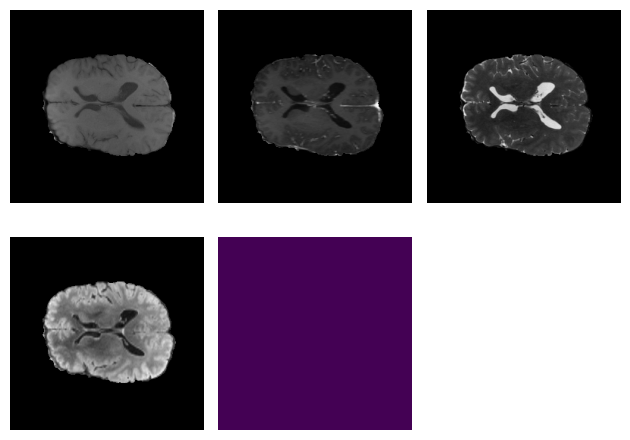

In [ ]:
visualize(130)

In [5]:
path = '/content/drive/MyDrive/diff_repaint/data/train_batch_0.npz'
loaded_data = np.load(path)

In [7]:
print(loaded_data['images'])

<bound method Mapping.keys of <numpy.lib.npyio.NpzFile object at 0x7fbbfc3979a0>>
